In [141]:
from IPython.display import HTML
import yaml
from animalai.envs.arena_config import ArenaConfig
from animalai.envs.environment import AnimalAIEnvironment
from mlagents_envs.exception import UnityCommunicationException
from mlagents_envs.base_env import ActionTuple
import random
import copy
import numpy as np
import math
from collections import defaultdict

In [142]:
conf_file = '/Users/aidancurtis/animalai-python/examples/configurations/curriculum/0.yml'
yaml_data = yaml.load(open(conf_file, "r"), Loader=yaml.Loader)

# random position
yaml_data.arenas[-1].items[0].positions[0].z = 10
# print(yaml_data.arenas[-1].items[0].positions[0].y)
# print(yaml_data.arenas[-1].items[0].positions[0].z)

# Pick a random goal pose and set the data state
goal_pose = (random.uniform(0, 40), 0, random.uniform(0, 40), 0)
yaml_data.arenas[-1].items[1].positions[0].x = goal_pose[0]
yaml_data.arenas[-1].items[1].positions[0].y = goal_pose[1]
yaml_data.arenas[-1].items[1].positions[0].z = goal_pose[2]


x = yaml_data.arenas[-1].items[0].positions[0].x
y = yaml_data.arenas[-1].items[0].positions[0].y
z = yaml_data.arenas[-1].items[0].positions[0].z
r = yaml_data.arenas[-1].items[0].rotations[0]

vx = yaml_data.arenas[-1].items[0].velocities[0].x
vy = yaml_data.arenas[-1].items[0].velocities[0].y
vz = yaml_data.arenas[-1].items[0].velocities[0].z

ACTIONS = [[1, 0],
          [1, 1], 
          [1, 2]]

framerate = 60
 
agent_start_pose = (x, y, z, r, vx, vy, vz)
print(goal_pose)


def new_pose(start_pose, vel):
    return list((start_pose[i]+vel[i] for i in range(4)))

def set_pose(data, node):
    cp_yaml_data = copy.deepcopy(data)
    cp_yaml_data.arenas[-1].items[0].positions[0].x = node.pose[0]
    cp_yaml_data.arenas[-1].items[0].positions[0].y = node.pose[1]
    cp_yaml_data.arenas[-1].items[0].positions[0].z = node.pose[2]
    
    cp_yaml_data.arenas[-1].items[0].rotations[0] = [node.pose[3]
    
    cp_yaml_data.arenas[-1].items[0].velocities[0].x = node.pose[4]
    cp_yaml_data.arenas[-1].items[0].velocities[0].y = node.pose[5]
    cp_yaml_data.arenas[-1].items[0].velocities[0].z = node.pose[6]

    return cp_yaml_data

(3.4282389085930554, 0, 14.549810869586137, 0)


In [143]:
# if(environment):
#     environment.close() # takes a few secondsenvironment.close()

resolution=16
try:
    environment = AnimalAIEnvironment(
            file_name='/Users/aidancurtis/build15',
            base_port=50389,
            resolution=resolution,
#             play=True,
            arenas_configurations=yaml_data,

        )
except UnityCommunicationException:
    # you'll end up here if you close the environment window directly
    # always try to close it from script
    environment.close()

In [72]:
environment.close()

In [144]:
class Node:
    def __init__(self, pose):
        self.pose = pose
    
        
class SearchGraph:
    def __init__(self):
        self.nodes = []
        self.edges = defaultdict(list)
        self.backward_edges = defaultdict(lambda: (None, None) )
    def add_node(self, start_node, new_node, action):
        self.nodes.append(new_node)
        if(start_node is not None):
            self.edges[start_node].append((new_node, action))
            self.backward_edges[new_node] = (start_node, action)
    def get_path(self, goal_node):
        trace, action = self.backward_edges[goal_node]
        actions = [(action, trace)]
        while(trace is not None):
            trace, action = self.backward_edges[trace]
            if(action is not None):
                actions.append((action, trace) )
        
        return list(reversed(actions))
            
def find_closest_node(nodes, pose):
    min_dist = float("inf")
    min_node = None
    for node in nodes:
        dist = np.linalg.norm(np.array(node.pose)[[0, 2]]-np.array(pose)[[0, 2]])
        if(dist<min_dist):
            min_dist = dist
            min_node = node
    return min_node, min_dist


        

[20.0, 0.4903539717197418, 10.024170875549316, 0.0, 0.0, -0.07079601287841797, 0.7457994222640991]
[20.001136779785156, 0.4903539717197418, 10.024139404296875, 6.000014305114746, 0.04070287197828293, -0.07079601287841797, 0.7445348501205444]
[19.998863220214844, 0.4903539717197418, 10.024139404296875, 354.0, -0.04070287197828293, -0.07079601287841797, 0.7445348501205444]
17.177522879875447


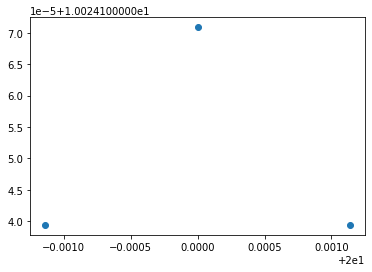

In [161]:
from matplotlib import pyplot as plt
points = []
graph = SearchGraph()


start_node = Node(agent_start_pose)
graph.add_node(None, start_node, None)
behavior_name = "AnimalAI?team=0"
dots = []
goal_found = False
for _ in range(1):
    # sample a pose
    goal_sample = 0.1
    if(np.random.uniform(0, 1) < goal_sample):
        sampled = goal_pose
    else:
        sampled = [np.random.uniform(0, 40), 0, np.random.uniform(0, 40), random.uniform(0, 360)]
    
    if(np.random.uniform(0, 1) < 0.5):
        
        min_node, _ = find_closest_node(graph.nodes, sampled)
    else:
        min_node = random.choice(graph.nodes)
    
    
    cur_node = min_node
    for action in ACTIONS:
       
        yaml_data = set_pose(yaml_data, cur_node)
        environment.reset(arenas_configurations=yaml_data)
        action = ActionTuple(discrete = np.array(action).reshape(1,2))
        cur_pose = np.array(cur_node.pose)
        cur_action = copy.deepcopy(action)
        environment.set_actions(behavior_name=behavior_name, action=cur_action)
        environment.step()
        step_result = environment.get_steps(behavior_name=behavior_name)[0]
        if(len(environment.get_steps(behavior_name=behavior_name)[1].obs[0]) > 0):
            goal_found = True
            break
            
        state_vec = (step_result.obs[1]).tolist()[0]
        print(state_vec)
        dots.append((state_vec[0], state_vec[2] ))
#         print(action.discrete)
#         print(cur_pose)
#         print(state_vec)
#         print("=====")


            
        new_node = Node(state_vec)
        graph.add_node(cur_node, new_node, cur_action)
    if(goal_found):
        break
    min_node, min_dist = find_closest_node(graph.nodes, goal_pose)
    if(min_dist < 0.8):
        break
    print(min_dist)

    
plan = graph.get_path(min_node)
plt.scatter([d[0] for d in dots], [d[1] for d in dots])



In [114]:
print(plan)

[(<mlagents_envs.base_env.ActionTuple object at 0x109713d30>, <__main__.Node object at 0x10994a8b0>), (<mlagents_envs.base_env.ActionTuple object at 0x1095cf550>, <__main__.Node object at 0x109713700>), (<mlagents_envs.base_env.ActionTuple object at 0x10951dd00>, <__main__.Node object at 0x10994a580>), (<mlagents_envs.base_env.ActionTuple object at 0x10939aeb0>, <__main__.Node object at 0x10951d040>), (<mlagents_envs.base_env.ActionTuple object at 0x10951d280>, <__main__.Node object at 0x10939a220>), (<mlagents_envs.base_env.ActionTuple object at 0x1091be6a0>, <__main__.Node object at 0x10939ab80>), (<mlagents_envs.base_env.ActionTuple object at 0x1091be160>, <__main__.Node object at 0x1091be730>), (<mlagents_envs.base_env.ActionTuple object at 0x1091be5e0>, <__main__.Node object at 0x1091be130>), (<mlagents_envs.base_env.ActionTuple object at 0x1091be6d0>, <__main__.Node object at 0x1091be9a0>), (<mlagents_envs.base_env.ActionTuple object at 0x1091beb80>, <__main__.Node object at 0x10

[20.0, 0.4903539717197418, 10.024170875549316, 0.0, 0.0, -0.07079601287841797, 0.7457994222640991]
[20.0, 0.4900028109550476, 10.117385864257812, 0.0, 0.0, -0.0005674362182617188, 1.956742763519287]
[20.0, 0.49000003933906555, 10.2797212600708, 0.0, 0.0, -4.76837158203125e-06, 3.0650508403778076]
[20.0, 0.49000003933906555, 10.503392219543457, 0.0, 0.0, 0.0, 4.045906066894531]
[20.0, 0.49000003933906555, 10.781330108642578, 0.0, 0.0, 0.0, 4.913705825805664]

[20.0, 0.9638065695762634, 11.13665771484375, 0.0, 0.0, -0.7093968391418457, 4.173438549041748]
[20.0, 0.9025524258613586, 11.367560386657715, 0.0, 0.0, -1.1703840494155884, 3.6923909187316895]
[20.0, 0.8157933950424194, 11.57184886932373, 0.0, 0.0, -1.5782358646392822, 3.2667911052703857]
[20.0, 0.7064692378044128, 11.752589225769043, 0.0, 0.0, -1.9390770196914673, 2.890247344970703]
[20.0, 0.5771809816360474, 11.912496566772461, 0.0, 0.0, -2.2583260536193848, 2.557105779647827]


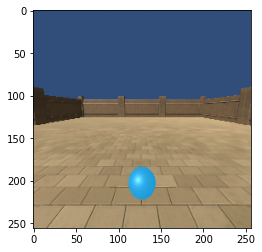

In [181]:
# environment.close() # takes a few secondsenvironment.close()
resolution=256

environment = AnimalAIEnvironment(
        file_name='/Users/aidancurtis/build15',
        base_port=5053,
        resolution=resolution,
        arenas_configurations=yaml_data,

    )
    
# visualize plan
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import display, clear_output
import time

fig, ax = plt.subplots()
vals  = ax.imshow(np.zeros((resolution, resolution,3)))

graph = SearchGraph()
behavior_name = "AnimalAI?team=0"

yaml_data = set_pose(yaml_data, start_node)
environment.reset(arenas_configurations=yaml_data)
# for action, node in plan:
a = [1,0]
for _ in range(5):
    ac =  ActionTuple(discrete = np.array(a).reshape(1,2))
    environment.set_actions(behavior_name=behavior_name, action=ac)
    environment.step()
    step_result = environment.get_steps(behavior_name=behavior_name)[0]
    state_vec = (step_result.obs[1]).tolist()[0]
    print(state_vec)
    visual_observation = step_result.obs[0]
    vals.set_data(visual_observation.reshape((resolution, resolution,3)))
#     display(fig)
#     clear_output(wait=True)

print()
cur_node = Node(state_vec)
yaml_data = set_pose(yaml_data, cur_node)
environment.reset(arenas_configurations=yaml_data)
for _ in range(5):
    ac =  ActionTuple(discrete = np.array([0,0]).reshape(1,2))
    environment.set_actions(behavior_name=behavior_name, action=ac)
    environment.step()
    step_result = environment.get_steps(behavior_name=behavior_name)[0]
    state_vec = (step_result.obs[1]).tolist()[0]
    print(state_vec)
    visual_observation = step_result.obs[0]
    vals.set_data(visual_observation.reshape((resolution, resolution,3)))
#     display(fig)
#     clear_output(wait=True)
    



environment.close()

In [10]:
environment.close() # takes a few secondsenvironment.close()

UnityEnvironmentException: No Unity environment is loaded.